<a href="https://colab.research.google.com/github/Ubaid-Manzoor/N-Layer-Neural-Network-Using-TensorFlow-With-Mnist-Dataset/blob/master/N_Layer_CNN(Mnist_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.python.framework import ops
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

np.random.seed(1)

In [3]:
mnist = tf.keras.datasets.mnist

(X_train , y_train) , (X_test , y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
gray_scale = len(X_train.shape) == 3

In [0]:
y_train = tf.one_hot(y_train , len(np.unique(y_train)))
y_test = tf.one_hot(y_test , len(np.unique(y_test)))

In [6]:
if gray_scale:
  X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1] , X_train.shape[2] , 1)
  X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1] , X_test.shape[2] , 1)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
with tf.Session() as sess:
  y_train = sess.run(y_train)
  y_test = sess.run(y_test)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [0]:
def create_placeholders(n_H , n_W , n_C , n_y):
  
  X = tf.placeholder(shape=[None , n_H, n_W, n_C] , dtype=tf.float32 , name='X')
  Y = tf.placeholder(shape=[None, n_y] , dtype=tf.float32 , name="Y")
  
  return X,Y

In [0]:
def initialize_learning_parameters(shapes):
  tf.set_random_seed(1)
  L = len(shapes)+1
  parameters = {}
  for l in range(1,L):
    parameters["W" + str(l)] = tf.get_variable("W"+str(l) ,shapes["W"+str(l)],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    
  return parameters

In [0]:
def initialize_non_learning_parameters(stride,window_size):
  #create dict for non learnable parameters Like stride and max_pool Window size
  non_learn_para = {}

  for l in range(1,len(window_size)+1):
    non_learn_para["Conv_s"+str(l)] = stride[l-1][0]
    non_learn_para["Maxpool_s"+str(l)] = stride[l-1][1]
    non_learn_para["WS"+str(l)] = window_size[l-1]
  
  return non_learn_para

In [0]:
#dimension of Fully Connected Layer
FC_layer_dims = [10]  #Now i just used 1 FC layer there can be many

In [0]:
def first_half(X , parameters , non_learn_para):
  NLP = non_learn_para
  L = len(parameters)
  P = X
  for l in range(1,L+1):

    #Conv layer
    s = NLP["Conv_s"+str(l)] 
    Z = tf.nn.conv2d(P , parameters["W"+str(l)], strides=[1,s,s,1] , padding='SAME')
    #Relu
    A = tf.nn.relu(Z)
    #MaxPool
    f = NLP["WS"+str(l)]
    s = NLP["Maxpool_s"+str(l)]
    P = tf.nn.max_pool(A , ksize=[1,f,f,1] , strides= [1,s,s,1] , padding='SAME')

  return P

In [0]:
def second_half(P , layer_dims):
  L = len(layer_dims)
  for l in range(1,L+1):
    Z = tf.contrib.layers.fully_connected(P , layer_dims[l-1] , activation_fn=None)
  
  return Z

In [0]:
def forward_propagation(X , parameters,non_learn_para , FC_layer_dims):
  
  #run_first_half
  P = first_half(X,parameters , non_learn_para)

  #Flatten
  P_flatten = tf.contrib.layers.flatten(P)

  #run_second_half
  Z = second_half(P_flatten , FC_layer_dims)
  return Z

In [0]:
def compute_cost(Z , Y):

  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z , labels=Y))
  
  return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
  #Create a Parameters dict to Hold all Weights
  #The Weight_shape has to be create manually 
  parameters_shape = {}
  if gray_scale:
    Weight_shapes = [[4,4,1,5] , [3,3,5,10] , [2,2,10,15]]# length of Weight_Shape depends on number of layers
  else:
    Weight_shapes = [[4,4,3,5] , [3,3,5,10] , [2,2,10,15]]# length of Weight_Shape depends on number of layers
  for i,shape in enumerate(Weight_shapes):
    l=i+1
    parameters_shape["W"+str(l)] = shape
  
  #define non learning parameters 
  stride = [[1,3] , [1,2] , [1,2]] # [[stride of conv layer , stride for max pool layer],[],[]]
  window_size = [3,2,2] #[for first maxpool layer,for second,for third]

In [0]:
# tf.reset_default_graph()
# with tf.Session() as sess_test:
#   parameters = initialize_parameters(parameters_shape)
#   init = tf.global_variables_initializer()
#   sess_test.run(init)
#   print("W1 = " + str(parameters["W1"].eval().shape))
#   print("W2 = " + str(parameters["W2"].eval().shape))
#   print("W2 = " + str(parameters["W3"].eval().shape))

In [0]:
def model(X_train , Y_train , X_test , Y_test ,FC_layer_dims,parameters_shape, learning_rate=0.001 
          , num_epochs=50 , minibatch_size=64 , print_cost = True):
  
  tf.reset_default_graph()
  tf.set_random_seed(1)
  
  m , n_H0 , n_W0 , n_C0 = X_train.shape
  n_y = Y_train.shape[1]
  
    #create list to store the cost at each epochs
  costs = []
  #create placeholders
  X ,Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
  
  #initialize all weights
  parameters = initialize_learning_parameters(parameters_shape)
  
  #
  non_learn_para = initialize_non_learning_parameters(stride, window_size)

  #Forward propogate to calculate Z of layer L in first half
  Z = forward_propagation(X , parameters,non_learn_para , FC_layer_dims)
  
  #calculate Cost using ZL and Y
  cost = compute_cost(Z , Y)
  
  #Minimize the cost using Adam optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  
  # initialize all the global variable here (W and b are global varibles)
  init = tf.global_variables_initializer()
  seed = 0
  with tf.Session() as sess:
    sess.run(init)
    
    costs = []
    
    for epoch in range(num_epochs):
      
      epoch_cost = 0
      seed = seed+1
      
      minibatches = random_mini_batches(X_train , Y_train , minibatch_size , seed)
      
      for minibatch in minibatches:
        mini_X , mini_Y = minibatch

        _ , temp_cost = sess.run([optimizer , cost] , feed_dict = {X:mini_X , Y:mini_Y})
        
        epoch_cost += temp_cost
      
      if print_cost==True:
        print ("Cost after epoch %i: %f" % (epoch+1, epoch_cost))
      costs.append(epoch_cost)
    
    plt.plot(range(1,num_epochs+1) , costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.show()
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(Y,1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 1: 1804.686765
Cost after epoch 2: 283.461214
Cost after epoch 3: 183.314067
Cost after epoch 4: 139.733104
Cost after epoch 5: 114.856308
Cost after epoch 6: 99.969816
Cost after epoch 7: 88.638097
Cost after epoch 8: 82.217409
Cost after epoch 9: 76.650486
Cost after epoch 10: 71.895864
Cost after epoch 11: 67.215593
Cost after epoch 12: 63.986685
Cost after epoch 13: 61.209671
Cost after epoch 14: 58.753569
Cost after epoch 15: 56.200041
Cost after epoch 16: 53.553833
Cost after epoch 17: 53.571361
Cost after epoch 18: 52.940883
Cost after epoch 19: 51.278176
Cost after epoch 20: 50.923864
Cost after epoch 21: 48.794350
Cost after epoch 22: 49.885484
Cost after epoch 23: 49.301334
Cost after epoch 24: 47.595970
Cost after epoch 25: 47.136075
Cost after epoch 26: 46.820904
Cost a

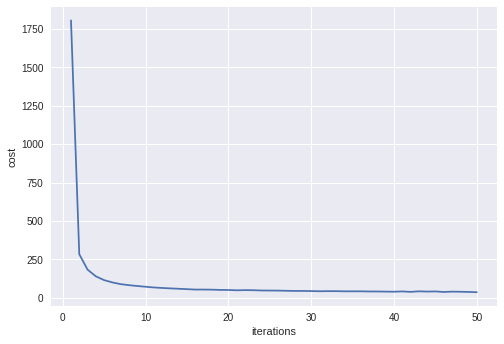

Train Accuracy: 0.9895667
Test Accuracy: 0.9808


In [20]:
parameters = model(X_train , y_train , X_test , y_test,FC_layer_dims,parameters_shape)